# SSVEP Character Classification with DiffE

In [1]:
#!pip install ema-pytorch

In [1]:
import os
import sys

#!git clone https://github.com/diffe2023/Diff-E.git
#sys.path.append('/content/Diff-E')
sys.path.append(r'C:\Users\shaoy\Diff-E')
#sys.path.append(r'C:\Users\shaoy\arl-eegmodels')

In [2]:
import math
from einops import reduce
from functools import partial
import random
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchaudio.transforms as T
from torch.utils.data import Dataset, DataLoader
from ema_pytorch import EMA
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    top_k_accuracy_score,
)

In [3]:
# Uncomment this if you want to use Google Drive
#from google.colab import drive
#drive.mount('/content/drive')

#load and preprocess data


We retain the original SSVEP data preprocessing procedures, including:

    Chebyshev bandpass filtering (6–90 Hz),
    Noise removal and segmentation using a sliding window of 250 samples, followed by manual channel-wise standardization (subtracting the mean and dividing by the standard deviation),
    Downsampling from 1000 Hz to 250 Hz.

In this work, we directly load the preprocessed character-level files "S#_chars.npy" for subsequent training.

Unlike the original setup where models are trained separately for each subject, we train a single model jointly across all subjects by concatenating all subjects' data.

In [4]:
# Define a function to perform z-score normalization on the data
def zscore_norm(data):
    # Calculate the mean and standard deviation for each channel in each batch
    mean = torch.mean(data, dim=(1, 2))
    std = torch.std(data, dim=(1, 2))

    # Subtract the mean from each channel in each batch and divide by the standard deviation
    norm_data = (data - mean[:, None, None]) / std[:, None, None]

    return norm_data


# Define a function to perform min-max normalization on the data
def minmax_norm(data):
    # Calculate the minimum and maximum values for each channel and sequence in the batch
    min_vals = torch.min(data, dim=-1)[0]
    max_vals = torch.max(data, dim=-1)[0]

    # Scale the data to the range [0, 1]
    norm_data = (data - min_vals.unsqueeze(-1)) / (
        max_vals.unsqueeze(-1) - min_vals.unsqueeze(-1)
    )

    return norm_data

In [5]:
class EEGDataset(Dataset):
    "Characterizes a dataset for PyTorch"

    def __init__(self, X, Y, transform=None):
        "Initialization"
        self.X = X
        self.Y = Y
        self.transform = transform

    def __len__(self):
        "Denotes the total number of samples"
        return len(self.X)

    def __getitem__(self, index):
        "Generates one sample of data"
        # Load data and get label
        x = self.X[index]
        y = self.Y[index]
        if self.transform:
            x = self.transform(x)
        return x.squeeze(), y

In [6]:
#define spectrogram
#time_frames = 1 + (signal_length - n_fft) // hop_length
#1 + (250 - 64) // 16 = 12 time frame
spectrogram_transform = T.Spectrogram(
    n_fft=64,       # width of window. original: 128, but then the time_frame will become 0 when downsampling
    win_length=None, # default: n_fft
    hop_length=16, # default: win_length // 2
    normalized=True
)

In [7]:
def load_data_by_session(root_dir, subject_id, session_idx_list):
    data = np.load(os.path.join(root_dir, f"S{subject_id}_chars.npy"))  # [26, 6, 64, 250]
    data = data[:, session_idx_list]  # [26, len(session), 64, 250]
    X = data.reshape(-1, 64, 250)  # [samples, 64, 250]
    Y = np.repeat(np.arange(26), len(session_idx_list))

    # transform to spectrogram
    X_spectrogram = []
    for sample in X:  # sample: [64, 250]
        spec_per_channel = []
        for ch in sample:
            ch_tensor = torch.tensor(ch, dtype=torch.float32)
            spec = spectrogram_transform(ch_tensor)  # [freq, time]
            spec_per_channel.append(spec)
        spec_tensor = torch.stack(spec_per_channel)  # [64, freq, time]
        X_spectrogram.append(spec_tensor)

    X_spectrogram = torch.stack(X_spectrogram)  # [samples, 64, freq, time]
    Y = torch.tensor(Y, dtype=torch.long)

    print("X shape after Spectrogram:", X_spectrogram.shape)  # [B, 64, freq≈33, time≈12]

    return X_spectrogram, Y


def load_split_dataset(root_dir, num_seen=25, seed=43):
    random.seed(seed)

    all_subjects = list(range(1, 36))
    seen_subjects = random.sample(all_subjects, num_seen)#25 seen
    unseen_subjects = [sid for sid in all_subjects if sid not in seen_subjects]#10 unseen

    split_cfg = {
        "train":  [(sid, [0, 1, 2, 3]) for sid in seen_subjects],
        "val":    [(sid, [4]) for sid in seen_subjects],
        "test1":  [(sid, [5]) for sid in seen_subjects],
        "test2":  [(sid, [0, 1, 2, 3, 4, 5]) for sid in unseen_subjects]
    }

    print(f"[Split] Seen subjects (train/val/test1): {seen_subjects}")
    print(f"[Split] Unseen subjects (test2): {unseen_subjects}")

    loaders = {}
    for split, sid_sess in split_cfg.items():
        X_all, Y_all = [], []
        for sid, sess in sid_sess:
            X, Y = load_data_by_session(root_dir, sid, sess)
            X_all.append(X)
            Y_all.append(Y)
        X_all = torch.cat(X_all, dim=0)
        Y_all = torch.cat(Y_all, dim=0)
        dataset = EEGDataset(X_all, Y_all)
        loaders[split] = DataLoader(dataset, batch_size=32, shuffle=(split == "train"))
    return loaders


In [8]:
seed = 44
random.seed(seed)
torch.manual_seed(seed)
print("Random Seed: ", seed)

Random Seed:  44


In [9]:
#subject_chars_dir = '/content/drive/MyDrive/project/dataset/ssvep/chars' # Where to store all character data
subject_chars_dir = r'C:\LTI 11785 Introduction to deep learning\project\SSVEP\chars' # Where to store all character data
subject_ids = list(range(1, 36)) #35 samples + 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 256
batch_size2 = 256
seed = 44
shuffle = True

# load all subjects' data
loaders = load_split_dataset(subject_chars_dir, num_seen=20, seed=seed)
train_loader = loaders["train"]
val_loader   = loaders["val"]
test1_loader = loaders["test1"]
test2_loader = loaders["test2"]


[Split] Seen subjects (train/val/test1): [27, 34, 8, 12, 13, 33, 10, 1, 30, 4, 19, 28, 26, 6, 17, 29, 31, 25, 11, 32]
[Split] Unseen subjects (test2): [2, 3, 5, 7, 9, 14, 15, 16, 18, 20, 21, 22, 23, 24, 35]
X shape after Spectrogram: torch.Size([104, 64, 33, 16])
X shape after Spectrogram: torch.Size([104, 64, 33, 16])
X shape after Spectrogram: torch.Size([104, 64, 33, 16])
X shape after Spectrogram: torch.Size([104, 64, 33, 16])
X shape after Spectrogram: torch.Size([104, 64, 33, 16])
X shape after Spectrogram: torch.Size([104, 64, 33, 16])
X shape after Spectrogram: torch.Size([104, 64, 33, 16])
X shape after Spectrogram: torch.Size([104, 64, 33, 16])
X shape after Spectrogram: torch.Size([104, 64, 33, 16])
X shape after Spectrogram: torch.Size([104, 64, 33, 16])
X shape after Spectrogram: torch.Size([104, 64, 33, 16])
X shape after Spectrogram: torch.Size([104, 64, 33, 16])
X shape after Spectrogram: torch.Size([104, 64, 33, 16])
X shape after Spectrogram: torch.Size([104, 64, 33, 

In [20]:
print(len(train_loader.dataset), len(val_loader.dataset), len(test1_loader.dataset), len(test2_loader.dataset))

for x, y in train_loader:
    print("X shape:", x.shape)
    print("Y shape:", y.shape)
    break  # the first batch

2080 520 520 2340
X shape: torch.Size([32, 64, 33, 16])
Y shape: torch.Size([32])


train: 20 seen subjects × 4 session × 26 = 2080

val: 20 × 1 × 26 = 520

test1: 20 × 1 × 26 = 520

test2: 15 unseen × 6 session × 26 = 2340

random choose 25 subjects as seen, the rest 10 as unseen

| Group Name | Subject Range   | Sessions Used         | Purpose                                  |
|------------|------------------|------------------------|-------------------------------------------|
| train      | seen subjects    | sessions [0, 1, 2, 3]  | Training (4 sessions)                     |
| val        | seen subjects    | session [4]            | Validation                                |
| test1      | seen subjects    | session [5]            | Test on unseen session of seen subjects  |
| test2      | unseen subjects  | sessions [0–5] (all)   | Test on unseen subjects                   |


#model

The overall model follows the original GitHub implementation, with a few necessary adjustments to align tensor time dimensions. Specifically, we aligned the temporal dimensions between up2 + temb and down1, up3 and x, and x_hat and x. These changes are clearly marked with comments in the code.




```
#transform from 1D to 2D:
current input: [batch_size, channels, freq_bins, time_frames]
original input: [batch_size, channels, time]

Replace all instances of Conv1d, MaxPool1d, and AvgPool1d with Conv2d, MaxPool2d, and AvgPool2d, respectively.
Also modify the AvgPool1d and MaxPool1d used in the Encoder and Decoder.
```



In [21]:
def safe_cat_and_add(a, b, temb):
    """
    Interpolates `a` to align with `b`, then adds `temb` (broadcasted) to `a`, and finally concatenates with `b`.

    Inputs:
        a: decoder upsampled output [B, C, F, T]
        b: encoder skip connection [B, C, F, T]
        temb: time embedding output, supports [B, C], [B, C, 1], etc., auto-adapts shape

    Output:
        Concatenated result [B, C_concat, F, T]
    """
    # Align spatial dimensions (freq, time)
    if a.shape[2:] != b.shape[2:]:
        a = F.interpolate(a, size=b.shape[2:], mode='nearest')

    # Normalize temb to shape [B, C, 1, 1]
    while temb.dim() < 4:
        temb = temb.unsqueeze(-1)
    if temb.dim() > 4:
        temb = temb.squeeze(-1)

    # Broadcast to shape [B, C, F, T]
    temb = temb.expand(-1, -1, a.shape[2], a.shape[3])

    # Element-wise addition and concatenation
    return torch.cat([a + temb, b], dim=1)

def safe_align_2d(x1, x2):
    """
    Align two 4D tensors in frequency and time dimensions (2D spatial alignment).

    Inputs:
        x1, x2: [B, C, F, T]

    Returns:
        Aligned x1, x2
    """
    target_freq = min(x1.shape[2], x2.shape[2])
    target_time = min(x1.shape[3], x2.shape[3])
    x1 = F.interpolate(x1, size=(target_freq, target_time), mode='nearest')
    x2 = F.interpolate(x2, size=(target_freq, target_time), mode='nearest')
    return x1, x2


In [22]:
#define diffE model
def get_padding(kernel_size, dilation=1):
    return int((kernel_size * dilation - dilation) / 2)


# Swish activation function
class Swish(nn.Module):
    def __init__(self):
        super().__init__()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return x * self.sigmoid(x)


class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


class WeightStandardizedConv2d(nn.Conv2d):
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        weight = self.weight
        mean = weight.mean(dim=(1,2,3), keepdim=True)
        var = weight.var(dim=(1,2,3), keepdim=True, unbiased=False)
        weight = (weight - mean) / (var + eps).sqrt()
        return F.conv2d(x, weight, self.bias, self.stride, self.padding, self.dilation, self.groups)


class ResidualConvBlock(nn.Module):
    def __init__(self, inc, outc, kernel_size, stride=1, gn=8):
        super().__init__()
        self.same_channels = inc == outc
        padding = kernel_size // 2
        self.conv = nn.Sequential(
            WeightStandardizedConv2d(inc, outc, kernel_size, stride, padding),
            nn.GroupNorm(gn, outc),
            nn.PReLU(),
        )

    def forward(self, x):
        x1 = self.conv(x)
        return (x + x1) / 2 if self.same_channels else x1


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, gn=8, factor=2):
        super().__init__()
        self.pool = nn.MaxPool2d(kernel_size=factor)
        self.layer = ResidualConvBlock(in_channels, out_channels, kernel_size, gn=gn)

    def forward(self, x):
        x = self.layer(x)
        return self.pool(x)


class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, gn=8, factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=factor, mode='nearest')
        self.layer = ResidualConvBlock(in_channels, out_channels, kernel_size, gn=gn)

    def forward(self, x):
        return self.layer(self.upsample(x))


class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        """
        generic one layer FC NN for embedding things
        """
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.PReLU(),
            nn.Linear(emb_dim, emb_dim),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ConditionalUNet(nn.Module):
    def __init__(self, in_channels, n_feat=256):
        super(ConditionalUNet, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat

        self.d1_out = n_feat * 1
        self.d2_out = n_feat * 2
        self.d3_out = n_feat * 3
        self.d4_out = n_feat * 4

        self.u1_out = n_feat
        self.u2_out = n_feat
        self.u3_out = n_feat
        self.u4_out = in_channels

        self.sin_emb = SinusoidalPosEmb(n_feat)
        # self.timeembed1 = EmbedFC(n_feat, self.u1_out)
        # self.timeembed2 = EmbedFC(n_feat, self.u2_out)
        # self.timeembed3 = EmbedFC(n_feat, self.u3_out)

        self.down1 = UnetDown(in_channels, self.d1_out, 1, gn=8, factor=2)
        self.down2 = UnetDown(self.d1_out, self.d2_out, 1, gn=8, factor=2)
        self.down3 = UnetDown(self.d2_out, self.d3_out, 1, gn=8, factor=2)

        self.up2 = UnetUp(self.d3_out, self.u2_out, 1, gn=8, factor=2)
        self.up3 = UnetUp(self.u2_out + self.d2_out, self.u3_out, 1, gn=8, factor=2)
        self.up4 = UnetUp(self.u3_out + self.d1_out, self.u4_out, 1, gn=8, factor=2)
        self.out = nn.Conv2d(self.u4_out + in_channels, in_channels, kernel_size=1)

    def forward(self, x, t):
        down1 = self.down1(x)  # 2000 -> 1000
        down2 = self.down2(down1)  # 1000 -> 500
        down3 = self.down3(down2)  # 500 -> 250

        temb = self.sin_emb(t).view(-1, self.n_feat, 1)  # [b, n_feat, 1]

        up1 = self.up2(down3)  # 250 -> 500
        #up2 = self.up3(torch.cat([up1 + temb, down2], 1))  # 500 -> 1000
        up2 = self.up3(safe_cat_and_add(up1, down2, temb))

        #up3 = self.up4(torch.cat([up2 + temb, down1], 1))  # 1000 -> 2000
        up3 = self.up4(safe_cat_and_add(up2, down1, temb))

        # Align the temporal dimension of up3 and x
        if up3.shape[-1] != x.shape[-1]:
            target_len = min(up3.shape[-1], x.shape[-1])
            up3 = F.interpolate(up3, size=target_len)
            x = F.interpolate(x, size=target_len)

        #out = self.out(torch.cat([up3, x], 1))  # 2000 -> 2000
        if x.shape[2:] != up3.shape[2:]:
            x = F.interpolate(x, size=up3.shape[2:], mode='nearest')

        out = self.out(torch.cat([up3, x], 1))

        down = (down1, down2, down3)
        up = (up1, up2, up3)
        return out, down, up


class Encoder(nn.Module):
    def __init__(self, in_channels, dim=512):
        super(Encoder, self).__init__()

        self.in_channels = in_channels
        self.e1_out = dim
        self.e2_out = dim
        self.e3_out = dim

        self.down1 = UnetDown(in_channels, self.e1_out, 1, gn=8, factor=2)
        self.down2 = UnetDown(self.e1_out, self.e2_out, 1, gn=8, factor=2)
        self.down3 = UnetDown(self.e2_out, self.e3_out, 1, gn=8, factor=2)

        self.avg_pooling = nn.AdaptiveAvgPool2d((1,1))
        self.max_pooling = nn.AdaptiveMaxPool2d((1,1))
        self.act = nn.Tanh()

    def forward(self, x0):
        # Down sampling
        dn1 = self.down1(x0)  # 2048 -> 1024
        dn2 = self.down2(dn1)  # 1024 -> 512
        dn3 = self.down3(dn2)  # 512 -> 256
        z = self.avg_pooling(dn3).view(-1, self.e3_out)  # [b, features]
        down = (dn1, dn2, dn3)
        out = (down, z)
        return out


class Decoder(nn.Module):
    def __init__(self, in_channels, n_feat=256, encoder_dim=512, n_classes=13):
        super(Decoder, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes
        self.e1_out = encoder_dim
        self.e2_out = encoder_dim
        self.e3_out = encoder_dim
        self.d1_out = n_feat
        self.d2_out = n_feat * 2
        self.d3_out = n_feat * 3
        self.u1_out = n_feat
        self.u2_out = n_feat
        self.u3_out = n_feat
        self.u4_out = in_channels

        # self.sin_emb = SinusoidalPosEmb(n_feat)
        # self.timeembed1 = EmbedFC(n_feat, self.e3_out)
        # self.timeembed2 = EmbedFC(n_feat, self.u2_out)
        # self.timeembed3 = EmbedFC(n_feat, self.u3_out)
        # self.contextembed1 = EmbedFC(self.e3_out, self.e3_out)
        # self.contextembed2 = EmbedFC(self.e3_out, self.u2_out)
        # self.contextembed3 = EmbedFC(self.e3_out, self.u3_out)

        # Unet up sampling
        self.up1 = UnetUp(self.d3_out + self.e3_out, self.u2_out, 1, gn=8, factor=2)
        self.up2 = UnetUp(self.d2_out + self.u2_out, self.u3_out, 1, gn=8, factor=2)
        self.up3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.Conv2d(self.d1_out + self.u3_out + in_channels * 2, in_channels, kernel_size=1),
        )

        # self.out = nn.Conv1d(self.u4_out+in_channels, in_channels, 1)
        self.pool = nn.AvgPool2d(kernel_size=2)

    def forward(self, x0, encoder_out, diffusion_out):
        # Encoder output
        down, z = encoder_out
        dn1, dn2, dn3 = down

        # DDPM output
        x_hat, down_ddpm, up, t = diffusion_out
        dn11, dn22, dn33 = down_ddpm

        # embed context, time step
        # temb = self.sin_emb(t).view(-1, self.n_feat, 1) # [b, n_feat, 1]
        # temb1 = self.timeembed1(temb).view(-1, self.e3_out, 1) # [b, features]
        # temb2 = self.timeembed2(temb).view(-1, self.u2_out, 1) # [b, features]
        # temb3 = self.timeembed3(temb).view(-1, self.u3_out, 1) # [b, features]
        # ct2 = self.contextembed2(z).view(-1, self.u2_out, 1) # [b, n_feat, 1]
        # ct3 = self.contextembed3(z).view(-1, self.u3_out, 1) # [b, n_feat, 1]

        # Up sampling
        up1 = self.up1(torch.cat([dn3, dn33.detach()], 1))
        up2 = self.up2(torch.cat([up1, dn22.detach()], 1))
        out = self.up3(
            torch.cat([self.pool(x0), self.pool(x_hat.detach()), up2, dn11.detach()], 1)
        )
        return out


class DiffE(nn.Module):
    def __init__(self, encoder, decoder, fc):
        super(DiffE, self).__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.fc = fc

    def forward(self, x0, ddpm_out):
        encoder_out = self.encoder(x0)
        decoder_out = self.decoder(x0, encoder_out, ddpm_out)
        fc_out = self.fc(encoder_out[1])
        return decoder_out, fc_out


class DecoderNoDiff(nn.Module):
    def __init__(self, in_channels, n_feat=256, encoder_dim=512, n_classes=13):
        super(DecoderNoDiff, self).__init__()

        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_classes = n_classes
        self.e1_out = encoder_dim
        self.e2_out = encoder_dim
        self.e3_out = encoder_dim
        self.u1_out = n_feat
        self.u2_out = n_feat
        self.u3_out = n_feat
        self.u4_out = n_feat

        self.sin_emb = SinusoidalPosEmb(n_feat)
        self.timeembed1 = EmbedFC(n_feat, self.e3_out)
        self.timeembed2 = EmbedFC(n_feat, self.u2_out)
        self.timeembed3 = EmbedFC(n_feat, self.u3_out)
        self.contextembed1 = EmbedFC(self.e3_out, self.e3_out)
        self.contextembed2 = EmbedFC(self.e3_out, self.u2_out)
        self.contextembed3 = EmbedFC(self.e3_out, self.u3_out)

        # Unet up sampling
        self.up2 = UnetUp(self.e3_out, self.u2_out, 1, gn=8, factor=2)
        self.up3 = UnetUp(self.e2_out + self.u2_out, self.u3_out, 1, gn=8, factor=2)
        # self.up4 = UnetUp(self.e1_out+self.u3_out, self.u4_out, 1, 1, gn=in_channels, factor=2, is_res=True)
        self.up4 = nn.Sequential(
            nn.Upsample(scale_factor=(2, 1), mode="nearest"),  # freq
            nn.Conv2d(self.u3_out + self.e1_out + in_channels, in_channels, kernel_size=1)
        )

        self.out = nn.Conv2d(self.u4_out, in_channels, kernel_size=1)
        self.pool = nn.AvgPool2d(kernel_size=(2, 1))  #  freq

    def forward(self, x0, x_hat, encoder_out, t):
        down, z = encoder_out
        dn1, dn2, dn3 = down
        tembd = self.sin_emb(t).view(-1, self.n_feat, 1)  # [b, n_feat, 1]
        tembd1 = self.timeembed1(self.sin_emb(t)).view(
            -1, self.e3_out, 1
        )  # [b, n_feat, 1]
        tembd2 = self.timeembed2(self.sin_emb(t)).view(
            -1, self.u2_out, 1
        )  # [b, n_feat, 1]
        tembd3 = self.timeembed3(self.sin_emb(t)).view(
            -1, self.u3_out, 1
        )  # [b, n_feat, 1]

        # Up sampling
        ddpm_loss = F.l1_loss(x0, x_hat, reduction="none")

        up2 = self.up2(dn3)  # 256 -> 512
        up3 = self.up3(torch.cat([up2, dn2], 1))  # 512 -> 1024
        out = self.up4(
            torch.cat([self.pool(x0), self.pool(x_hat), up3, dn1], 1)
        )  # 1024 -> 2048
        # out = self.out(torch.cat([out, x_hat], 1)) # 2048 -> 2048
        # out = self.out(out)
        return out


class LinearClassifier(nn.Module):
    def __init__(self, in_dim, latent_dim, emb_dim):
        super().__init__()
        self.linear_out = nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=latent_dim),
            nn.GroupNorm(4, latent_dim),
            nn.PReLU(),
            nn.Linear(in_features=latent_dim, out_features=latent_dim),
            nn.GroupNorm(4, latent_dim),
            nn.PReLU(),
            nn.Linear(in_features=latent_dim, out_features=emb_dim),
        )

    def forward(self, x):
        x = self.linear_out(x)
        return x


def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule
    as proposed in https://openreview.net/forum?id=-NEXDKk8gZ
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype=torch.float64) / timesteps
    alphas_cumprod = torch.cos((t + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


def sigmoid_beta_schedule(timesteps, start=-3, end=3, tau=1, clamp_min=1e-5):
    """
    sigmoid schedule
    proposed in https://arxiv.org/abs/2212.11972 - Figure 8
    """
    steps = timesteps + 1
    t = torch.linspace(0, timesteps, steps, dtype=torch.float64) / timesteps
    v_start = torch.tensor(start / tau).sigmoid()
    v_end = torch.tensor(end / tau).sigmoid()
    alphas_cumprod = (-((t * (end - start) + start) / tau).sigmoid() + v_end) / (
        v_end - v_start
    )
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0, 0.999)


def ddpm_schedules(beta1, beta2, T):
    # assert beta1 < beta2 < 1.0, "beta1 and beta2 must be in (0, 1)"
    # beta_t = (beta2 - beta1) * torch.arange(0, T + 1, dtype=torch.float32) / T + beta1
    beta_t = cosine_beta_schedule(T, s=0.008).float()
    # beta_t = sigmoid_beta_schedule(T).float()

    alpha_t = 1 - beta_t

    log_alpha_t = torch.log(alpha_t)
    alphabar_t = torch.cumsum(log_alpha_t, dim=0).exp()

    sqrtab = torch.sqrt(alphabar_t)

    sqrtmab = torch.sqrt(1 - alphabar_t)

    return {
        "sqrtab": sqrtab,  # \sqrt{\bar{\alpha_t}}
        "sqrtmab": sqrtmab,  # \sqrt{1-\bar{\alpha_t}}
    }


class DDPM(nn.Module):
    def __init__(self, nn_model, betas, n_T, device):
        super(DDPM, self).__init__()
        self.nn_model = nn_model.to(device)

        for k, v in ddpm_schedules(betas[0], betas[1], n_T).items():
            self.register_buffer(k, v)

        self.n_T = n_T
        self.device = device

    def forward(self, x):
        _ts = torch.randint(1, self.n_T, (x.shape[0],)).to(
            self.device
        )  # t ~ Uniform(0, n_T)
        noise = torch.randn_like(x)  # eps ~ N(0, 1)
        #x_t = self.sqrtab[_ts, None, None] * x + self.sqrtmab[_ts, None, None] * noise
        x_t = self.sqrtab[_ts].view(-1, 1, 1, 1) * x + self.sqrtmab[_ts].view(-1, 1, 1, 1) * noise
        times = _ts / self.n_T
        output, down, up = self.nn_model(x_t, times)
        return output, down, up, noise, times

In [23]:
for x, y in train_loader:
    channels = x.shape[1]
    timepoints = x.shape[2]
    print(f"Sample input shape: {x.shape}  → Channels: {channels}, Timepoints: {timepoints}")
    break

num_classes = 26
ddpm_dim = 128
encoder_dim = 256
fc_dim = 512
n_T = 1000

ddpm_model = ConditionalUNet(in_channels=channels, n_feat=ddpm_dim).to(device)
ddpm = DDPM(nn_model=ddpm_model, betas=(1e-6, 1e-2), n_T=n_T, device=device).to(device)

encoder = Encoder(in_channels=channels, dim=encoder_dim).to(device)
decoder = Decoder(in_channels=channels, n_feat=ddpm_dim, encoder_dim=encoder_dim).to(device)



Sample input shape: torch.Size([32, 64, 33, 16])  → Channels: 64, Timepoints: 33


In [24]:
fc = LinearClassifier(encoder_dim, fc_dim, emb_dim=num_classes).to(device)

diffe = DiffE(encoder, decoder, fc).to(device)

print(" Model initialized with:")
print(" - Input channels       :", channels)
print(" - Timepoints           :", timepoints)
print(" - ddpm total params    :", sum(p.numel() for p in ddpm.parameters()))
print(" - encoder total params :", sum(p.numel() for p in encoder.parameters()))
print(" - decoder total params :", sum(p.numel() for p in decoder.parameters()))
print(" - classifier params    :", sum(p.numel() for p in fc.parameters()))
print(" - total DiffE params   :", sum(p.numel() for p in diffe.parameters()))

 Model initialized with:
 - Input channels       : 64
 - Timepoints           : 33
 - ddpm total params    : 265478
 - encoder total params : 149763
 - decoder total params : 156482
 - classifier params    : 409628
 - total DiffE params   : 715873


#train

In [25]:
# Criterion
criterion = nn.L1Loss()
criterion_class = nn.MSELoss()

# Define optimizer
base_lr, lr = 9e-5, 1.5e-3
optim1 = optim.RMSprop(ddpm.parameters(), lr=base_lr)
optim2 = optim.RMSprop(diffe.parameters(), lr=base_lr)

# EMAs
fc_ema = EMA(diffe.fc, beta=0.95, update_after_step=100, update_every=10,)

step_size = 150
scheduler1 = optim.lr_scheduler.CyclicLR(
    optimizer=optim1,
    base_lr=base_lr,
    max_lr=lr,
    step_size_up=step_size,
    mode="exp_range",
    cycle_momentum=False,
    gamma=0.9998,
)
scheduler2 = optim.lr_scheduler.CyclicLR(
    optimizer=optim2,
    base_lr=base_lr,
    max_lr=lr,
    step_size_up=step_size,
    mode="exp_range",
    cycle_momentum=False,
    gamma=0.9998,
)

In [26]:
# Evaluate function
def evaluate(encoder, fc, generator, device):
    labels = np.arange(0, 26)
    Y = []
    Y_hat = []
    for x, y in generator:
        x, y = x.to(device), y.type(torch.LongTensor).to(device)
        encoder_out = encoder(x)
        y_hat = fc(encoder_out[1])
        y_hat = F.softmax(y_hat, dim=1)

        Y.append(y.detach().cpu())
        Y_hat.append(y_hat.detach().cpu())

    # List of tensors to tensor to numpy
    Y = torch.cat(Y, dim=0).numpy()  # (N, )
    Y_hat = torch.cat(Y_hat, dim=0).numpy()  # (N, 13): has to sum to 1 for each row

    # Accuracy and Confusion Matrix
    accuracy = top_k_accuracy_score(Y, Y_hat, k=1, labels=labels)
    f1 = f1_score(Y, Y_hat.argmax(axis=1), average="macro", labels=labels)
    recall = recall_score(Y, Y_hat.argmax(axis=1), average="macro", labels=labels)
    precision = precision_score(Y, Y_hat.argmax(axis=1), average="macro", labels=labels, zero_division=0)
    auc = roc_auc_score(Y, Y_hat, average="macro", multi_class="ovo", labels=labels)

    metrics = {
        "accuracy": accuracy,
        "f1": f1,
        "recall": recall,
        "precision": precision,
        "auc": auc,
    }
    # df_cm = pd.DataFrame(confusion_matrix(Y, Y_hat.argmax(axis=1)))
    return metrics


In [27]:
from torchsummary import summary

class EEGNet(nn.Module):
    def __init__(self, nb_classes, Chans=64, Samples=128, 
                 dropoutRate=0.25, kernLength=64, F1=8, D=2, F2=16):
        super(EEGNet, self).__init__()

        self.nb_classes = nb_classes
        self.Chans = Chans
        self.Samples = Samples
        self.F1 = F1
        self.D = D
        self.F2 = F2
        self.dropoutRate = dropoutRate

        # Block 1: Temporal Convolution
        self.conv1 = nn.Conv2d(1, F1, (1, kernLength), padding=(0, kernLength // 2), bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)

        # Block 1: Depthwise Convolution (Spatial Filtering)
        self.depthwiseConv = nn.Conv2d(F1, F1*D, (Chans, 1), groups=F1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(F1*D)
        self.elu = nn.ELU()
        self.avgpool1 = nn.AvgPool2d((1, 4))
        self.dropout = nn.Dropout(dropoutRate)

        # Block 2: Separable Convolution
        self.separableConv = nn.Conv2d(F1*D, F2, (1, 16), padding=(0, 8), bias=False)
        self.batchnorm3 = nn.BatchNorm2d(F2)
        self.avgpool2 = nn.AvgPool2d((1, 8))

        # Classification Layer
        self.classify = nn.Linear(self._calc_out_features(), nb_classes)

    def _calc_out_features(self):
        # Helper to calculate output size after convolutions/pooling
        with torch.no_grad():
            x = torch.zeros(1, 1, self.Chans, self.Samples)
            x = self.conv1(x)
            x = self.batchnorm1(x)
            x = self.depthwiseConv(x)
            x = self.batchnorm2(x)
            x = self.elu(x)
            x = self.avgpool1(x)
            x = self.dropout(x)

            x = self.separableConv(x)
            x = self.batchnorm3(x)
            x = self.elu(x)
            x = self.avgpool2(x)
            x = self.dropout(x)

            return x.numel()

    def forward(self, x):
        # x shape: (batch_size, Chans, Samples)
        x = x.unsqueeze(1)  # shape: (batch_size, 1, Chans, Samples)

        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.depthwiseConv(x)
        x = self.batchnorm2(x)
        x = self.elu(x)
        x = self.avgpool1(x)
        x = self.dropout(x)

        x = self.separableConv(x)
        x = self.batchnorm3(x)
        x = self.elu(x)
        x = self.avgpool2(x)
        x = self.dropout(x)

        x = x.reshape(x.size(0), -1)
        x = self.classify(x)

        return x


eegnet_model = EEGNet(nb_classes=num_classes, Chans=64, Samples=512, dropoutRate=0.4)

eegnet_model = eegnet_model.to(device)

optimizer = torch.optim.Adam(eegnet_model.parameters(), lr=0.001)
criterion_eeg = nn.CrossEntropyLoss()

summary(eegnet_model, input_size=(64, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 8, 64, 513]             512
       BatchNorm2d-2           [-1, 8, 64, 513]              16
            Conv2d-3           [-1, 16, 1, 513]           1,024
       BatchNorm2d-4           [-1, 16, 1, 513]              32
               ELU-5           [-1, 16, 1, 513]               0
         AvgPool2d-6           [-1, 16, 1, 128]               0
           Dropout-7           [-1, 16, 1, 128]               0
            Conv2d-8           [-1, 16, 1, 129]           4,096
       BatchNorm2d-9           [-1, 16, 1, 129]              32
              ELU-10           [-1, 16, 1, 129]               0
        AvgPool2d-11            [-1, 16, 1, 16]               0
          Dropout-12            [-1, 16, 1, 16]               0
           Linear-13                   [-1, 26]           6,682
Total params: 12,394
Trainable params: 

In [28]:
'''Initiate Wandb.'''

'Initiate Wandb.'

In [29]:
import wandb

# Use wandb? Resume Training?
USE_WANDB = True

RESUME_LOGGING = False # Set this to true if you are resuming training from a previous run

# Create your wandb run

run_name = '{}_project_ssvep_diff'.format('Ben')

# If you are resuming an old run
if USE_WANDB:

    wandb.login(key="207d89e5e9cdfc415370f05503c72a11d5065073") #TODO

    if RESUME_LOGGING:
        run = wandb.init(
            id     = "diff-CAE(fc)-EEG", ### Insert specific run id here if you want to resume a previous run
            resume = "must", ### You need this to resume previous runs
            project = "project_ssvep-ablations", ### Project should be created in your wandb
            settings = wandb.Settings(_service_wait=300)
        )


    else:
        run = wandb.init(
            name    = run_name, ### Wandb creates random run names if you skip this field, we recommend you give useful names
            reinit  = True, ### Allows reinitalizing runs when you re-run this cell
            project = "project_ssvep-ablations", ### Project should be created in your wandb account
            #config  = config ### Wandb Config for your run
        )

        ### Save your model architecture as a string with str(model)
        model_arch  = str([ddpm, diffe, eegnet_model])
        ### Save it in a txt file
        arch_file   = open("model_arch.txt", "w")
        file_write  = arch_file.write(model_arch)
        arch_file.close()

        ### log it in your wandb run with wandb.save()
        wandb.save('model_arch.txt')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [30]:
# Train & Evaluate
args = argparse.Namespace()
args.device = device
args.subject = "ALL"
args.root_dir = subject_chars_dir
subject = args.subject

num_epochs = 500
test_period = 1
start_test = test_period
alpha = 0
beta = 1

best_acc = 0
best_f1 = 0
best_recall = 0
best_precision = 0
best_auc = 0

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

with tqdm(total=num_epochs, desc=f"Method ALL - Joint Training on All Subjects - Autoencoders") as pbar:
    for epoch in range(num_epochs):
        ddpm.train()
        diffe.train()

        epoch_loss = 0
        num_batches = 0
        epoch_acc = 0
        total_samples = 0

        ############################## Train ###########################################
        for x, y in train_loader:
            x, y = x.to(device), y.type(torch.LongTensor).to(device)
            y_cat = F.one_hot(y, num_classes=26).type(torch.FloatTensor).to(device)
            # Train DDPM
            optim1.zero_grad()
            x_hat, down, up, noise, t = ddpm(x)

            # Align the temporal dimension of x_hat and x
            x_hat, x = safe_align_2d(x_hat, x)

            loss_ddpm = F.l1_loss(x_hat, x, reduction="none")
            loss_ddpm.mean().backward()
            optim1.step()
            ddpm_out = x_hat, down, up, t

            # Train Diff-E
            optim2.zero_grad()
            decoder_out, fc_out = diffe(x, ddpm_out)

            loss_gap = criterion(decoder_out, loss_ddpm.detach())
            loss_c = criterion_class(fc_out, y_cat)
            loss = beta * loss_gap + alpha * loss_c
            loss.backward()
            optim2.step()

            # Optimizer scheduler step
            scheduler1.step()
            scheduler2.step()

            # EMA update
            fc_ema.update()

            epoch_loss += loss.item()
            num_batches += 1

            pred_labels = torch.argmax(fc_out, dim=1)
            correct = (pred_labels == y).sum().item()
            epoch_acc += correct
            total_samples += y.size(0)

        history["train_loss"].append(epoch_loss / num_batches)
        history["train_acc"].append(epoch_acc / total_samples)

        ############################## validation ###########################################
        with torch.no_grad():
            if epoch > start_test:
                test_period = 1
            if epoch % test_period == 0:
                ddpm.eval()
                diffe.eval()

                metrics_val = evaluate(diffe.encoder, fc_ema, val_loader, device)

                val_acc = metrics_val["accuracy"]
                history["val_acc"].append(val_acc)
                f1 = metrics_val["f1"]
                recall = metrics_val["recall"]
                precision = metrics_val["precision"]
                auc = metrics_val["auc"]

                val_loss = 0
                with torch.no_grad():
                    for x, y in val_loader:
                        x, y = x.to(device), y.type(torch.LongTensor).to(device)
                        y_cat = F.one_hot(y, num_classes=26).float().to(device)

                        x_hat, down, up, noise, t = ddpm(x)
                        ddpm_out = x_hat, down, up, t

                        # Align the temporal dimension of x_hat and x
                        x_hat, x = safe_align_2d(x_hat, x)

                        loss_ddpm = F.l1_loss(x_hat, x, reduction="none")
                        decoder_out, fc_out = diffe(x, ddpm_out)

                        loss_gap = criterion(decoder_out, loss_ddpm)
                        loss_c = criterion_class(fc_out, y_cat)

                        val_loss += (beta * loss_gap + alpha * loss_c).item()
                history["val_loss"].append(val_loss / len(val_loader))

                best_acc_bool = val_acc > best_acc
                best_f1_bool = f1 > best_f1
                best_recall_bool = recall > best_recall
                best_precision_bool = precision > best_precision
                best_auc_bool = auc > best_auc

                if best_acc_bool:
                    best_acc = val_acc
                    #torch.save(diffe.state_dict(), f'/content/drive/MyDrive/project/model/ssvep/diffe_{subject}.pth')
                    torch.save(ddpm.state_dict(), r'C:\LTI 11785 Introduction to deep learning\project\SSVEP\checkpoints_separated\ddpm_all_subjects.pth')
                    torch.save(diffe.state_dict(), r'C:\LTI 11785 Introduction to deep learning\project\SSVEP\checkpoints_separated\diffe_all_subjects.pth')
                if best_f1_bool:
                    best_f1 = f1
                if best_recall_bool:
                    best_recall = recall
                if best_precision_bool:
                    best_precision = precision
                if best_auc_bool:
                    best_auc = auc

                description = f"Val Accuracy: {val_acc*100:.2f}% | Best: {best_acc*100:.2f}%"
                pbar.set_description(f"Method ALL – Processing subject {subject} – {description}"
                )
        #print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {history['train_loss'][-1]:.4f} | Val Acc: {val_acc*100:.2f}%")
        print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {history['train_loss'][-1]:.4f} | Valid Loss: {history['val_loss'][-1]:.4f}")
        pbar.update(1)

Method ALL - Joint Training on All Subjects - Autoencoders:   0%|          | 0/500 [00:00<?, ?it/s]

[Epoch 1/500] Train Loss: 0.6439 | Valid Loss: 0.5142
[Epoch 2/500] Train Loss: 0.4850 | Valid Loss: 0.4586
[Epoch 3/500] Train Loss: 0.4238 | Valid Loss: 0.3849
[Epoch 4/500] Train Loss: 0.3757 | Valid Loss: 0.3678
[Epoch 5/500] Train Loss: 0.3625 | Valid Loss: 0.3494
[Epoch 6/500] Train Loss: 0.3712 | Valid Loss: 0.4028
[Epoch 7/500] Train Loss: 0.3980 | Valid Loss: 0.3827
[Epoch 8/500] Train Loss: 0.3529 | Valid Loss: 0.3322
[Epoch 9/500] Train Loss: 0.3330 | Valid Loss: 0.3273
[Epoch 10/500] Train Loss: 0.3343 | Valid Loss: 0.3485
[Epoch 11/500] Train Loss: 0.3652 | Valid Loss: 0.3704
[Epoch 12/500] Train Loss: 0.3706 | Valid Loss: 0.3285
[Epoch 13/500] Train Loss: 0.3373 | Valid Loss: 0.3219
[Epoch 14/500] Train Loss: 0.3248 | Valid Loss: 0.3235
[Epoch 15/500] Train Loss: 0.3312 | Valid Loss: 0.3764
[Epoch 16/500] Train Loss: 0.3605 | Valid Loss: 0.3800
[Epoch 17/500] Train Loss: 0.3431 | Valid Loss: 0.3081
[Epoch 18/500] Train Loss: 0.3186 | Valid Loss: 0.3129
[Epoch 19/500] Trai

In [22]:
#val_losses = []
#val_accuracies = []
#initializer = RandomNormal(mean=0.0, stddev=0.1)

In [31]:
def evaluate2(diffe, ddpm, EEGNet, generator, device):
    labels = np.arange(0, 26)
    Y = []
    Y_hat = []
    for x, y in generator:
        x, y = x.to(device), y.type(torch.LongTensor).to(device)
        y_cat = F.one_hot(y, num_classes=26).type(torch.FloatTensor).to(device)

        x_hat, down, up, noise, t = ddpm(x)

        # Align the temporal dimension of x_hat and x
        x_hat, x = safe_align_2d(x_hat, x)

        ddpm_out = x_hat, down, up, t

        decoder_out, fc_out = diffe(x, ddpm_out)
        
        X_eegnet = decoder_out.view(decoder_out.size(0), 64, -1)  # (samples, 64, 396)
        y_hat = EEGNet(X_eegnet)
        
        y_hat = F.softmax(y_hat, dim=1)

        Y.append(y.detach().cpu())
        Y_hat.append(y_hat.detach().cpu())

    # List of tensors to tensor to numpy
    Y = torch.cat(Y, dim=0).numpy()  # (N, )
    Y_hat = torch.cat(Y_hat, dim=0).numpy()  # (N, 13): has to sum to 1 for each row

    # Accuracy and Confusion Matrix
    accuracy = top_k_accuracy_score(Y, Y_hat, k=1, labels=labels)
    f1 = f1_score(Y, Y_hat.argmax(axis=1), average="macro", labels=labels)
    recall = recall_score(Y, Y_hat.argmax(axis=1), average="macro", labels=labels)
    precision = precision_score(Y, Y_hat.argmax(axis=1), average="macro", labels=labels, zero_division=0)
    auc = roc_auc_score(Y, Y_hat, average="macro", multi_class="ovo", labels=labels)

    metrics = {
        "accuracy": accuracy,
        "f1": f1,
        "recall": recall,
        "precision": precision,
        "auc": auc,
    }
    # df_cm = pd.DataFrame(confusion_matrix(Y, Y_hat.argmax(axis=1)))
    return metrics

In [32]:
# Train & Evaluate
'''args = argparse.Namespace()
args.device = device
args.subject = "ALL"
args.root_dir = subject_chars_dir
subject = args.subject'''

num_epochs = 100
test_period = 1
start_test = test_period
alpha = 1
beta = 0

'''best_acc = 0
best_f1 = 0
best_recall = 0
best_precision = 0
best_auc = 0

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}'''

with tqdm(total=num_epochs, desc=f"Method ALL - Joint Training on All Subjects - EEGNet") as pbar:
    for epoch in range(num_epochs):
        ddpm.train()
        diffe.train()
        eegnet_model.train()

        epoch_loss = 0
        num_batches = 0
        epoch_acc = 0
        total_samples = 0

        ############################## Train ###########################################
        for x, y in train_loader:
            x, y = x.to(device), y.type(torch.LongTensor).to(device)
            y_cat = F.one_hot(y, num_classes=26).type(torch.FloatTensor).to(device)

            x_hat, down, up, noise, t = ddpm(x)

            # Align the temporal dimension of x_hat and x
            x_hat, x = safe_align_2d(x_hat, x)

            ddpm_out = x_hat, down, up, t

            # Train Diff-E
            decoder_out, fc_out = diffe(x, ddpm_out)

            # EMA update
            #fc_ema.update()
            #print(decoder_out.shape)
            X_eegnet = decoder_out.view(decoder_out.size(0), 64, -1)  # (samples, 64, 396)
            #print(X_eegnet.shape)
            outputs = eegnet_model(X_eegnet)
            
            loss = criterion_eeg(outputs, y_cat)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            num_batches += 1

            pred_labels = torch.argmax(outputs, dim=1)
            correct = (pred_labels == y).sum().item()
            epoch_acc += correct
            total_samples += y.size(0)

        history["train_loss"].append(epoch_loss / num_batches)
        history["train_acc"].append(epoch_acc / total_samples)

        ############################## validation ###########################################
        eegnet_model.eval()
        with torch.no_grad():
            if epoch > start_test:
                test_period = 1
            if epoch % test_period == 0:
                ddpm.eval()
                diffe.eval()

                metrics_val = evaluate2(diffe, ddpm, eegnet_model, val_loader, device)

                val_acc = metrics_val["accuracy"]
                history["val_acc"].append(val_acc)
                f1 = metrics_val["f1"]
                recall = metrics_val["recall"]
                precision = metrics_val["precision"]
                auc = metrics_val["auc"]

                val_loss = 0
                with torch.no_grad():
                    for x, y in val_loader:
                        x, y = x.to(device), y.type(torch.LongTensor).to(device)
                        y_cat = F.one_hot(y, num_classes=26).float().to(device)

                        x_hat, down, up, noise, t = ddpm(x)
                        ddpm_out = x_hat, down, up, t

                        # Align the temporal dimension of x_hat and x
                        x_hat, x = safe_align_2d(x_hat, x)

                        #loss_ddpm = F.l1_loss(x_hat, x, reduction="none")
                        decoder_out, fc_out = diffe(x, ddpm_out)

                        X_eegnet = decoder_out.view(decoder_out.size(0), 64, -1)  # (samples, 64, 396)
                        outputs = eegnet_model(X_eegnet)

                        val_loss += criterion_eeg(outputs, y).item()

                
                history["val_loss"].append(val_loss / len(val_loader))

                best_acc_bool = val_acc > best_acc
                best_f1_bool = f1 > best_f1
                best_recall_bool = recall > best_recall
                best_precision_bool = precision > best_precision
                best_auc_bool = auc > best_auc

                if best_acc_bool:
                    best_acc = val_acc
                    #torch.save(diffe.state_dict(), f'/content/drive/MyDrive/project/model/ssvep/diffe_{subject}.pth')
                    #torch.save(diffe.state_dict(), '/content/drive/MyDrive/project/model/ssvep/diffe_all_subjects.pth')
                    torch.save(eegnet_model.state_dict(), r'C:\LTI 11785 Introduction to deep learning\project\SSVEP\checkpoints_separated\eegnet_model_all_subjects.pth')
                if best_f1_bool:
                    best_f1 = f1
                if best_recall_bool:
                    best_recall = recall
                if best_precision_bool:
                    best_precision = precision
                if best_auc_bool:
                    best_auc = auc

                description = f"Val Accuracy: {val_acc*100:.2f}% | Best: {best_acc*100:.2f}%"
                pbar.set_description(f"Method ALL – Processing subject {subject} – {description}"
                )
        print(f"[Epoch {epoch+1}/{num_epochs}] Train Loss: {history['train_loss'][-1]:.4f} | Val Acc: {val_acc*100:.2f}%")
        pbar.update(1)

Method ALL - Joint Training on All Subjects - EEGNet:   0%|          | 0/100 [00:00<?, ?it/s]

[Epoch 1/100] Train Loss: 3.2627 | Val Acc: 11.15%
[Epoch 2/100] Train Loss: 2.8482 | Val Acc: 20.77%
[Epoch 3/100] Train Loss: 2.3274 | Val Acc: 30.77%
[Epoch 4/100] Train Loss: 2.0928 | Val Acc: 32.31%
[Epoch 5/100] Train Loss: 1.9728 | Val Acc: 34.81%
[Epoch 6/100] Train Loss: 1.8807 | Val Acc: 33.65%
[Epoch 7/100] Train Loss: 1.8425 | Val Acc: 37.31%
[Epoch 8/100] Train Loss: 1.8009 | Val Acc: 36.92%
[Epoch 9/100] Train Loss: 1.7317 | Val Acc: 38.27%
[Epoch 10/100] Train Loss: 1.7191 | Val Acc: 38.08%
[Epoch 11/100] Train Loss: 1.6914 | Val Acc: 40.38%
[Epoch 12/100] Train Loss: 1.6430 | Val Acc: 38.85%
[Epoch 13/100] Train Loss: 1.6428 | Val Acc: 40.00%
[Epoch 14/100] Train Loss: 1.5805 | Val Acc: 38.27%
[Epoch 15/100] Train Loss: 1.5809 | Val Acc: 41.54%
[Epoch 16/100] Train Loss: 1.5375 | Val Acc: 40.77%
[Epoch 17/100] Train Loss: 1.5416 | Val Acc: 40.77%
[Epoch 18/100] Train Loss: 1.5371 | Val Acc: 41.15%
[Epoch 19/100] Train Loss: 1.4975 | Val Acc: 39.62%
[Epoch 20/100] Train 

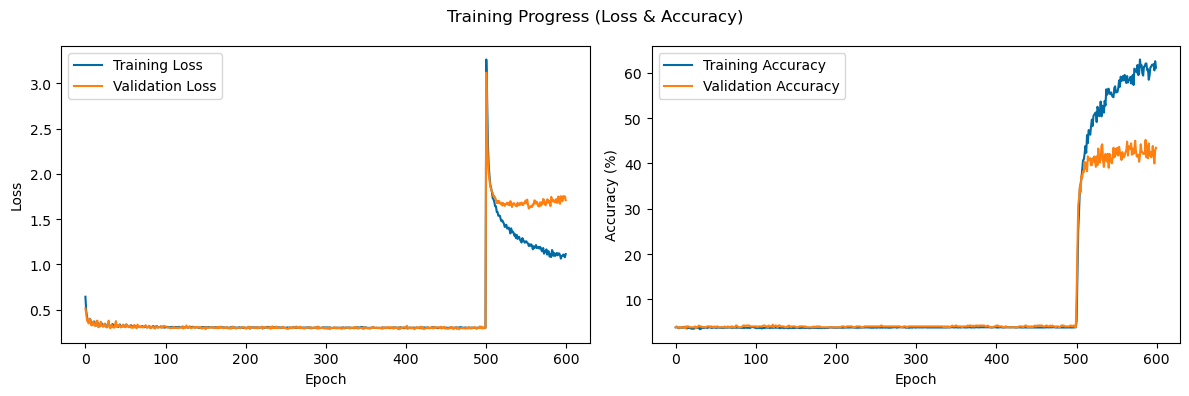

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.style.use('tableau-colorblind10')

# Plot training & validation loss
plt.subplot(1, 2, 1)
plt.plot(history["train_loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

# Plot training & validation accuracy
plt.subplot(1, 2, 2)
plt.plot([v * 100 for v in history["train_acc"]], label="Training Accuracy")
plt.plot([v * 100 for v in history["val_acc"]], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

plt.suptitle("Training Progress (Loss & Accuracy)")
plt.tight_layout()
plt.show()

In [34]:
def evaluate_on_loader(test_loader, name="test"):
    diffe.eval()
    labels = np.arange(0, 26)
    Y, Y_hat = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.type(torch.LongTensor).to(device)
            y_cat = F.one_hot(y, num_classes=26).type(torch.FloatTensor).to(device)

            x_hat, down, up, noise, t = ddpm(x)

            # Align the temporal dimension of x_hat and x
            x_hat, x = safe_align_2d(x_hat, x)

            ddpm_out = x_hat, down, up, t

            # Train Diff-E
            decoder_out, fc_out = diffe(x, ddpm_out)

            # EMA update
            #fc_ema.update()
            #print(decoder_out.shape)
            X_eegnet = decoder_out.view(decoder_out.size(0), 64, -1)  # (samples, 64, 396)
            #print(X_eegnet.shape)
            outputs = eegnet_model(X_eegnet)

            #encoder_out = diffe.encoder(x)
            #y_hat = diffe.fc(encoder_out[1])
            y_hat = F.softmax(outputs, dim=1)

            Y.append(y.detach().cpu())
            Y_hat.append(y_hat.detach().cpu())

    Y = torch.cat(Y, dim=0).numpy()
    Y_hat = torch.cat(Y_hat, dim=0).numpy()

    accuracy = top_k_accuracy_score(Y, Y_hat, k=1, labels=labels)
    print(f" {name} Accuracy: {accuracy:.2%}")
    return accuracy

#Evaluate on test data

In [35]:
acc1 = evaluate_on_loader(test1_loader, name="Test1 (Seen Subject)")
acc2 = evaluate_on_loader(test2_loader, name="Test2 (Unseen Subject)")

 Test1 (Seen Subject) Accuracy: 42.12%
 Test2 (Unseen Subject) Accuracy: 40.85%


In [36]:
if USE_WANDB:
    run.finish()